In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.api import qqplot,add_constant
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse
%matplotlib inline
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.model_selection import train_test_split
import matplotlib
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import graphviz
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
from sklearn.decomposition import PCA
warnings.simplefilter('ignore')
matplotlib.rc('font',family = 'AppleGothic')
matplotlib.rc('axes',unicode_minus=False)
import statsmodels.api as sm
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA

## (1) 데이터 구성하기

In [2]:
df_raw=pd.read_csv("/Users/lee/Week3/환율.csv",engine="python",encoding='cp949',parse_dates=["APPL_DATE"])
df_raw.head()

,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
0,CNY,2016-01-01,181.48,0.1541
1,JPY,2016-01-01,976.99,0.8294
2,USD,2016-01-01,1178.00,1.0000
3,CNY,2016-01-02,181.48,0.1541
4,JPY,2016-01-02,976.99,0.8294


## (2) 변동 추세 확인 - 시간에 따른 환율 추세 그래프 생성

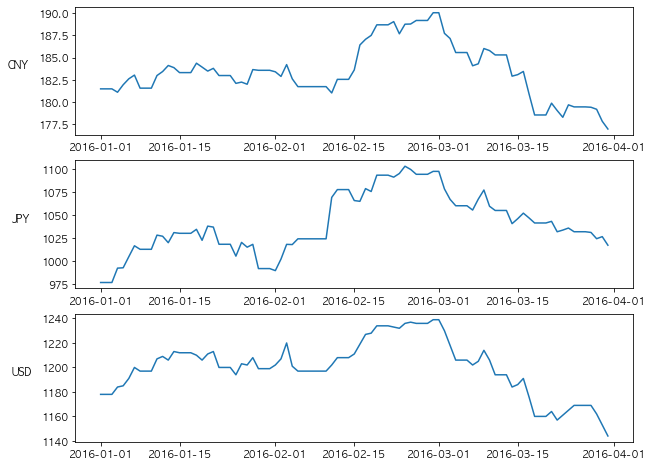

In [4]:
# 중국 위엔화와 엔화/달러 단위 크기가 다르기 때문에 각각의 그래프 생성 3행 1열 크기 (10.8)
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3,ncols=1,figsize=(10,8))
for(ax,idx,currency) in zip([ax1,ax2,ax3],[311,312,313],["CNY","JPY","USD"]):
    ax.plot("APPL_DATE","STD_RATE",data=df_raw[df_raw["CURRENCY"]==currency])
    ax.set_ylabel(currency,rotation=0,labelpad=20)

## (3) 시계열 분석 : 데이터 분할 - 통화별 데이터 분할

In [5]:
df_CNY=df_raw[df_raw["CURRENCY"]=='CNY'].set_index("APPL_DATE")
df_CNY.drop(["CURRENCY","USD_CONV_DATE"],axis=1,inplace=True)
df_JPY=df_raw[df_raw["CURRENCY"]=="JPY"].set_index("APPL_DATE")
df_JPY.drop(["CURRENCY","USD_CONV_DATE"],axis=1,inplace=True)
df_USD=df_raw[df_raw["CURRENCY"]=="USD"].set_index("APPL_DATE")
df_USD.drop(["CURRENCY","USD_CONV_DATE"],axis=1,inplace=True)
df_CNY.head()

,STD_RATE
APPL_DATE,
2016-01-01,181.48
2016-01-02,181.48
2016-01-03,181.48
2016-01-04,181.10
2016-01-05,181.94


## (4) 시계열 분석 : 데이터 분할 - train/test 데이터 분할

In [6]:
# train & test 데이터 분할 : 비율 기준 Mask 지정
train_size = 0.9
len_idx=len(df_CNY.index)
mask=(np.arange(len_idx)/len_idx)<train_size
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False])

In [7]:
df_CNY_train=df_CNY[mask]
df_CNY_test=df_CNY[~mask]
print("shape of train data:{}".format(df_CNY_train.shape))
print("shape of train data:{}".format(df_CNY_test.shape))

shape of train data:(82, 1)
shape of train data:(9, 1)


In [ ]:
#추가 분할
## df_CNY_train=df_CNY[df_CNY.index<="2016-03-22"]
## df_CNY_test=df_CNY[df_CNY.index<="2016-03-22"]
## df_CNY_test.head()

## (5) 시계열 분석 : 데이터 분할 - 차분을 통한 데이터를 정상성데이터로 변환

<AxesSubplot:xlabel='APPL_DATE'>

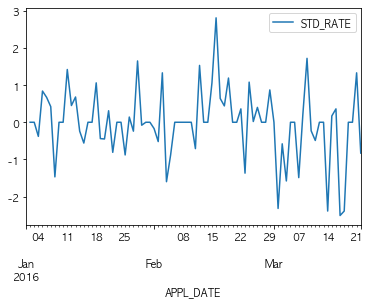

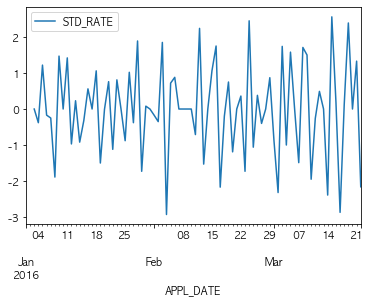

In [8]:
# 1차 차분
df_CNY_diff1=df_CNY_train-df_CNY_train.shift(1)
df_CNY_diff1.plot()

# 2차 차분
df_CNY_diff2 = df_CNY_train-2*(df_CNY_train.shift(1))+(df_CNY_train.shift(2))
df_CNY_diff2.plot()

## (6) 시계열 분석 : 자기상관 함수 및 부분 자기상관 함수

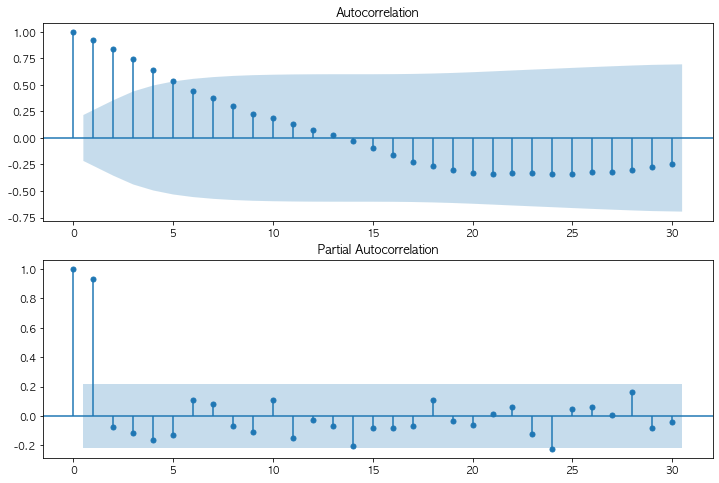

In [9]:
lag_size = 30
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=plot_acf(df_CNY_train["STD_RATE"],lags=lag_size,ax=ax1)
ax2=fig.add_subplot(212)
fig =plot_pacf(df_CNY_train["STD_RATE"],lags=lag_size,ax=ax2)

## (7) 시계열 모델

In [10]:
ts_model_cny=ARIMA(df_CNY_train,order=(1,2,0))

ts_result_cny=ts_model_cny.fit(trend="c",full_output=True)
print(ts_result_cny.summary())

                             ARIMA Model Results                              
Dep. Variable:            D2.STD_RATE   No. Observations:                   80
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -123.512
Method:                       css-mle   S.D. of innovations              1.132
Date:                Thu, 20 May 2021   AIC                            253.025
Time:                        22:33:53   BIC                            260.171
Sample:                    01-03-2016   HQIC                           255.890
                         - 03-22-2016                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0022      0.088     -0.024      0.981      -0.175       0.171
ar.L1.D2.STD_RATE    -0.4389      0.102     -4.322      0.000      -0.638      -0.240
                        

## (8) 예측 및 결과 해석

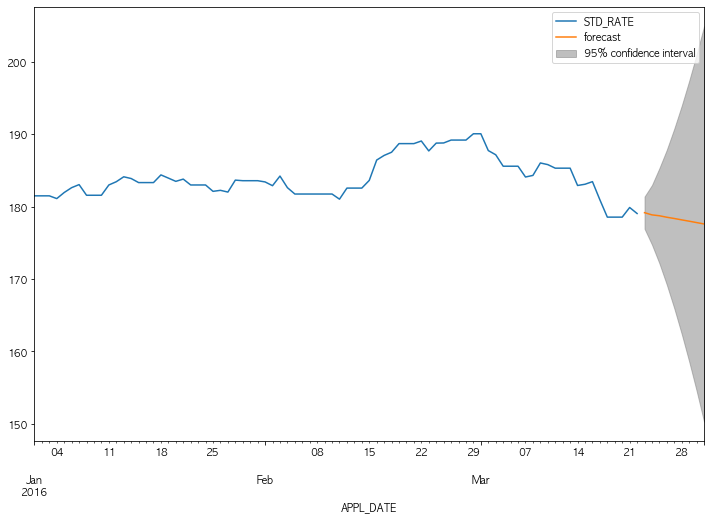

In [11]:
start_time=df_CNY_test.index.min()
end_time=df_CNY_test.index.max()
fig,ax=plt.subplots(figsize=(12,8))

ax=df_CNY_train.plot(ax=ax)
fig = ts_result_cny.plot_predict(start=start_time,end=end_time,ax=ax,plot_insample=False)

## (9) 예측 및 결과 해석

<AxesSubplot:xlabel='APPL_DATE'>

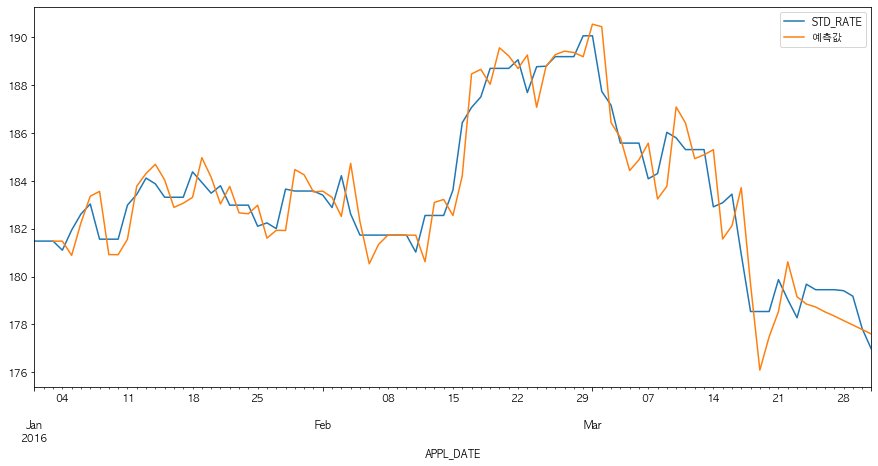

In [12]:
start_time = pd.to_datetime("2016-01-03")
y_pred=ts_result_cny.predict(start=start_time,end=end_time,typ='levels')
df_merge=df_CNY
df_merge["예측값"]=y_pred
df_merge.head()

df_merge.plot(y=["STD_RATE","예측값"],figsize=(15,7))